# Adam: Exercise

For this exercise we will be build Adam up from scratch starting with regular gradient descent. We will also be utilizing mini batches to introduce stochasticity to the optimization. 

We will be working with the mnist_784 data set and a simple shallow neural network. 

If you do not have scikit-learn then you can get it here: https://scikit-learn.org/stable/install.html

This code is heavily inspired by Doug’s code from CSCI 447/547 lecture 05_multilayer_perceptron.

First we need to get the data, define the network and define some functions to perform on the data. You don’t need to do anything with this first block of code. 

In [2]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# In order to run this in class, we're going to reduce the dataset by a factor of 5
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X[::5]
y = y.astype(int)[::5]
X, X_test, y, y_test = train_test_split(X, y)

# Here we specify the size of our neural network.
# We are mapping from 784 to 10 with 256 hiden layer nodes.

m = len(X)
n_0 = 784
n_1 = 256
N = 10


# Function to convert categorical labels into one-hot matrix.
def convert_to_one_hot(y, n_classes):
    T = np.zeros((y.shape[0], n_classes))
    for t, yy in zip(T, y):
        t[yy] = 1
    return T


# Convert the data to one hot notation
one_hot_y_actual = convert_to_one_hot(y, N)
one_hot_y_test = convert_to_one_hot(y_test, N)


# Sigmoid function (activation)
def sigmoid(a):
    return 1. / (1 + np.exp(-a))


# Softmax function (final layer for classification)
def softmax(A):
    numerator = np.exp(A)
    denominator = numerator.sum(axis=1)
    return numerator / denominator[:, np.newaxis]


# Categorical cross-entropy
def L(T, S, W1, W2, alpha_1=1e-2, alpha_2=1e-5):
    return -1. / len(T) * np.sum(T * np.log(S)) + np.sum(0.5 * alpha_1 * W1 ** 2) + np.sum(0.5 * alpha_2 * W2 ** 2)


# Run the neural network forward, given some weights and biases
def feedforward(X, W1, W2, b1, b2):
    # Feedforward
    A1 = X @ W1 + b1
    Z1 = sigmoid(A1)
    A2 = Z1 @ W2 + b2
    y_pred = softmax(A2)
    return y_pred, Z1


# Compute the neural network gradients using backpropagation
def backpropogate(y_pred, Z1, X, y_obs, alpha_1=1e-2, alpha_2=1e-5):
    # Backpropogate
    delta_2 = (1. / len(y_pred)) * (y_pred - y_obs)
    grad_W2 = Z1.T @ delta_2 + alpha_2 * W2
    grad_b2 = delta_2.sum(axis=0)

    delta_1 = delta_2 @ W2.T * Z1 * (1 - Z1)
    grad_W1 = X.T @ delta_1 + alpha_1 * W1
    grad_b1 = delta_1.sum(axis=0)
    return grad_W1, grad_W2, grad_b1, grad_b2


def mini_batch(x_sample, y_sample, start_batch_size):
    """
    Takes a copy of x_sample and y_sample and returns mini batch matrices of both and number of batches
    """

    # Batches must divide evenly into total number of samples for numpy arrays to be happy.
    # Gets number of bathes by finding next smallest number that evenly divides
    num_batches = start_batch_size
    while len(x_sample) % num_batches != 0:
        num_batches -= 1

    # randomly shuffle indices
    np.random.seed(42)
    random_indices = np.random.choice(range(len(x_sample)), len(x_sample), replace=False)

    # instantiate lists to hold batches
    x_list = [[] for i in range(num_batches)]
    y_list = [[] for i in range(num_batches)]

    # populate batches matrix with random mini batch indices
    for i in range(len(x_sample)):

        x_list[i // 105].append(x_sample[random_indices[i]])
        y_list[i // 105].append(y_sample[random_indices[i]])
    
    # Convert to numpy arrays
    x_batch = np.array(x_list)
    y_batch = np.array(y_list)

    return x_batch, y_batch, num_batches, num_batches


# Vanilla Gradient Descent

For our first exercise we will implement plain old gradient descent. The mathematical formula is:

$$ \theta_t = \theta_{t-1} - \alpha \nabla f(\theta_{t-1}) \tag{1}$$
---

We have already specified initial values for the $\alpha$ and the batch size but feel free to play around with it. The location to insert your gradient descent implementation is outlined with a multi-line comment.  

In [3]:
"""
Vanilla Gradient Descent
"""

# Hyper Parameters
eta = 1e-5
initial_batch_size = 104
epochs = 250

# Initialize random parameter matrices
np.random.seed(42)
W1 = 0.001 * np.random.randn(n_0, n_1)
W2 = 0.001 * np.random.randn(n_1, N)

b1 = 0.1 * np.random.randn(1, n_1)
b2 = 0.1 * np.random.randn(1, N)

# data for analysis
vanilla_loss = []

# Perform gradient descent
for i in range(epochs):

    # generate mini batches
    x_batches, y_batches, num_batches, actual_batch_size = mini_batch(X, one_hot_y_actual, initial_batch_size)

    # perform gradient descent on mini batches
    for j in range(num_batches):
        y_pred, Z1 = feedforward(x_batches[j], W1, W2, b1, b2)
        
        """
        These are your gradients with respect to weight matrices W1 and W2 
        as well as your biases b1 and b2
        """
        grad_W1, grad_W2, grad_b1, grad_b2 = backpropogate(y_pred, Z1, x_batches[j], y_batches[j])

        W1 -= eta*grad_W1
        b1 -= eta*grad_b1
        
        W2 -= eta*grad_W2
        b2 -= eta*grad_b2


    # calc loss at end of each epoch
    y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
    vanilla_loss.append(L(one_hot_y_actual, y_entire_pred, W1, W2))

    # Print some summary statistics every ten iterations
    if i % 10 == 0:
        y_pred_test, Z1_test = feedforward(X_test, W1, W2, b1, b2)
        acc = sum(y_test == np.argmax(y_pred_test, axis=1)) / len(y_test)
        y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
        print("Epoch %d Loss %f Accuracy %f" % (i, L(one_hot_y_actual, y_entire_pred, W1, W2), acc))


Epoch 0 Loss 2.305675 Accuracy 0.096857
Epoch 10 Loss 2.296826 Accuracy 0.096857
Epoch 20 Loss 2.287383 Accuracy 0.096857
Epoch 30 Loss 2.276882 Accuracy 0.137429
Epoch 40 Loss 2.265052 Accuracy 0.195143
Epoch 50 Loss 2.251730 Accuracy 0.261143
Epoch 60 Loss 2.236832 Accuracy 0.359429
Epoch 70 Loss 2.220377 Accuracy 0.469714
Epoch 80 Loss 2.202490 Accuracy 0.553714
Epoch 90 Loss 2.183331 Accuracy 0.594857
Epoch 100 Loss 2.163061 Accuracy 0.611714
Epoch 110 Loss 2.141848 Accuracy 0.623143
Epoch 120 Loss 2.119855 Accuracy 0.625714
Epoch 130 Loss 2.097231 Accuracy 0.630286
Epoch 140 Loss 2.074114 Accuracy 0.629429
Epoch 150 Loss 2.050625 Accuracy 0.628286
Epoch 160 Loss 2.026863 Accuracy 0.628857
Epoch 170 Loss 2.002922 Accuracy 0.629429
Epoch 180 Loss 1.978904 Accuracy 0.633143
Epoch 190 Loss 1.954887 Accuracy 0.637143
Epoch 200 Loss 1.930927 Accuracy 0.640286
Epoch 210 Loss 1.907072 Accuracy 0.641714
Epoch 220 Loss 1.883365 Accuracy 0.642286
Epoch 230 Loss 1.859840 Accuracy 0.645429
Epo

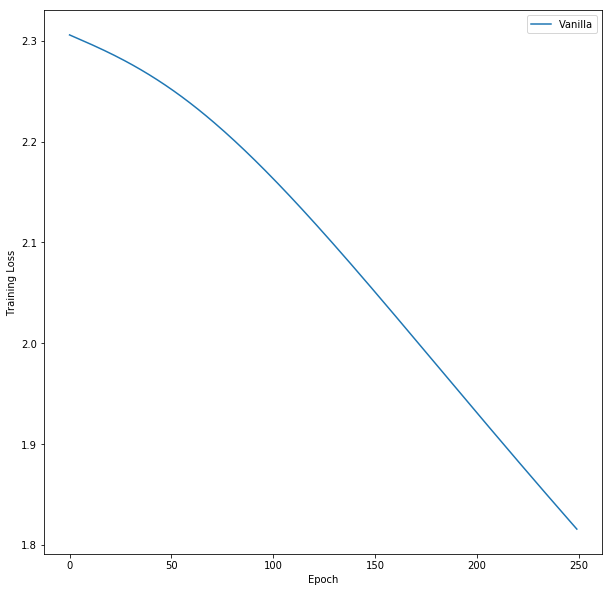

In [8]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10,10)

plt.plot(vanilla_loss, label='Vanilla')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.show()

# Momentum Gradient Descent

Next we will add momentum. The the new update rule is:

$$m_{t}=\beta_{1} m_{t-1} + (1 - \beta_{1})\nabla f(\theta_{t-1})$$
---

$$ \beta_1 \in [0,1)$$
---

$$\theta_{t}=\theta_{t-1} - \alpha m_{t} \tag{2}$$
---

In [5]:

"""
Momentum Gradient Descent
"""

# Hyper Parameters
eta = 1e-5
initial_batch_size = 104
epochs = 250
beta = 0.9

# data for analysis
momentum_loss = []

# Initialize random parameter matrices
np.random.seed(42)
W1 = 0.001 * np.random.randn(n_0, n_1)
W2 = 0.001 * np.random.randn(n_1, N)

b1 = 0.1 * np.random.randn(1, n_1)
b2 = 0.1 * np.random.randn(1, N)

m_t_w1 = np.zeros_like(W1)
m_t_w2 = np.zeros_like(W2)
m_t_b1 = np.zeros_like(b1)
m_t_b2 = np.zeros_like(b2)

# Perform gradient descent
for i in range(epochs):

    # generate mini batches
    x_batches, y_batches, num_batches, actual_batch_size = mini_batch(X, one_hot_y_actual, initial_batch_size)

    # perform gradient descent on mini batches
    for j in range(num_batches):
        y_pred, Z1 = feedforward(x_batches[j], W1, W2, b1, b2)

        """
        These are your gradients with respect to weight matrices W1 and W2 
        as well as your biases b1 and b2
        """

        
        grad_W1, grad_W2, grad_b1, grad_b2 = backpropogate(y_pred, Z1, x_batches[j], y_batches[j])
        
        m_t_w1 = beta*m_t_w1 + (1-beta)*grad_W1
        m_t_w2 = beta*m_t_w2 + (1-beta)*grad_W2
        m_t_b1 = beta*m_t_b1 + (1-beta)*grad_b1
        m_t_b2 = beta*m_t_b2 + (1-beta)*grad_b2

        
        W1 -= eta*m_t_w1
        W2 -= eta*m_t_w2
        b1 -= eta*m_t_b1
        b2 -= eta*m_t_b2

    # calc loss at end of each epoch
    y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
    momentum_loss.append(L(one_hot_y_actual, y_entire_pred, W1, W2))

    # Print some summary statistics every ten iterations
    if i % 10 == 0:
        y_pred_test, Z1_test = feedforward(X_test, W1, W2, b1, b2)
        acc = sum(y_test == np.argmax(y_pred_test, axis=1)) / len(y_test)
        y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
        print("Epoch %d Loss %f Accuracy %f" % (i, L(one_hot_y_actual, y_entire_pred, W1, W2), acc))


Epoch 0 Loss 2.305754 Accuracy 0.096857
Epoch 10 Loss 2.296912 Accuracy 0.096857
Epoch 20 Loss 2.287492 Accuracy 0.096857
Epoch 30 Loss 2.277021 Accuracy 0.136857
Epoch 40 Loss 2.265226 Accuracy 0.194857
Epoch 50 Loss 2.251945 Accuracy 0.260857
Epoch 60 Loss 2.237088 Accuracy 0.357429
Epoch 70 Loss 2.220674 Accuracy 0.468571
Epoch 80 Loss 2.202825 Accuracy 0.552857
Epoch 90 Loss 2.183702 Accuracy 0.594857
Epoch 100 Loss 2.163464 Accuracy 0.611714
Epoch 110 Loss 2.142279 Accuracy 0.623143
Epoch 120 Loss 2.120310 Accuracy 0.625429
Epoch 130 Loss 2.097707 Accuracy 0.630286
Epoch 140 Loss 2.074607 Accuracy 0.629714
Epoch 150 Loss 2.051132 Accuracy 0.628857
Epoch 160 Loss 2.027382 Accuracy 0.628857
Epoch 170 Loss 2.003450 Accuracy 0.629429
Epoch 180 Loss 1.979438 Accuracy 0.633143
Epoch 190 Loss 1.955424 Accuracy 0.636571
Epoch 200 Loss 1.931466 Accuracy 0.640571
Epoch 210 Loss 1.907613 Accuracy 0.642000
Epoch 220 Loss 1.883905 Accuracy 0.642286
Epoch 230 Loss 1.860378 Accuracy 0.645143
Epo

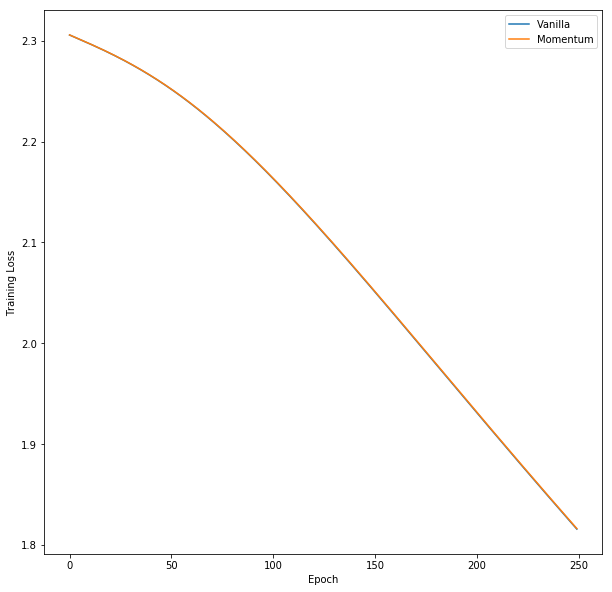

In [11]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10,10)

plt.plot(vanilla_loss, label='Vanilla')
plt.plot(momentum_loss, label='Momentum')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.show()

# RMSProp Gradient Descent 

Next we will do RMSProp. The update rule is as follows:

$$v_{t} = \beta_{2}v_{t-1} + (1 - \beta_{2})\nabla f(\theta_{t-1})^2$$
---

$$ \beta_2 \in [0,1)$$
---

$$\theta_{t} = \theta_{t-1} - \alpha \frac { \nabla f(\theta_{t-1})}{\sqrt{v_{t} + \epsilon}} \tag{3}$$ 
---


In [6]:
"""
RMSProp Gradient Descent
"""

# Hyper Parameters
eta = 1e-5
initial_batch_size = 104
epochs = 250
"""
You need to add two hyper parameters here. Hint! look at the equation above
"""


# Initialize random parameter matrices
np.random.seed(42)
W1 = 0.001 * np.random.randn(n_0, n_1)
W2 = 0.001 * np.random.randn(n_1, N)

b1 = 0.1 * np.random.randn(1, n_1)
b2 = 0.1 * np.random.randn(1, N)

# data for analysis
RMS_loss = []

beta2 = 0.9999999
lil_eta = 1e-9

v2W1 = np.zeros_like(W1)
v2W2 = np.zeros_like(W2)
v2b1 = np.zeros_like(b1)
v2b2 = np.zeros_like(b2)


# Perform gradient descent
for i in range(epochs):

    # generate mini batches
    x_batches, y_batches, num_batches, actual_batch_size = mini_batch(X, one_hot_y_actual, initial_batch_size)

    # perform gradient descent on mini batches
    for j in range(num_batches):
        y_pred, Z1 = feedforward(x_batches[j], W1, W2, b1, b2)

        """
        These are your gradients with respect to weight matrices W1 and W2 
        as well as your biases b1 and b2
        """
        grad_W1, grad_W2, grad_b1, grad_b2 = backpropogate(y_pred, Z1, x_batches[j], y_batches[j])

        v2W1 = beta2*v2W1 + (1-beta2)*(grad_W1**2)
        v2W2 = beta2*v2W2 + (1-beta2)*(grad_W2**2)
        v2b1 = beta2*v2b1 + (1-beta2)*(grad_b1**2)
        v2b2 = beta2*v2b2 + (1-beta2)*(grad_b2**2)

        
        W1 -= eta*grad_W1/np.sqrt(v2W1 + lil_eta)
        W2 -= eta*grad_W2/np.sqrt(v2W2 + lil_eta)
        b1 -= eta*grad_b1/np.sqrt(v2b1 + lil_eta)
        b2 -= eta*grad_b2/np.sqrt(v2b2 + lil_eta)

  

       

    # calc loss at end of each epoch
    y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
    RMS_loss.append(L(one_hot_y_actual, y_entire_pred, W1, W2))

    # Print some summary statistics every ten iterations
    if i % 10 == 0:
        y_pred_test, Z1_test = feedforward(X_test, W1, W2, b1, b2)
        acc = sum(y_test == np.argmax(y_pred_test, axis=1)) / len(y_test)
        y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
        print("Epoch %d Loss %f Accuracy %f" % (i, L(one_hot_y_actual, y_entire_pred, W1, W2), acc))


Epoch 0 Loss 0.984000 Accuracy 0.745429
Epoch 10 Loss 0.525007 Accuracy 0.895429
Epoch 20 Loss 0.433259 Accuracy 0.908000
Epoch 30 Loss 0.351595 Accuracy 0.925143
Epoch 40 Loss 0.319311 Accuracy 0.928286
Epoch 50 Loss 0.265765 Accuracy 0.931714
Epoch 60 Loss 0.232941 Accuracy 0.933143
Epoch 70 Loss 0.229297 Accuracy 0.932000
Epoch 80 Loss 0.198523 Accuracy 0.932857
Epoch 90 Loss 0.185566 Accuracy 0.935714
Epoch 100 Loss 0.160723 Accuracy 0.935714
Epoch 110 Loss 0.148970 Accuracy 0.936857
Epoch 120 Loss 0.127660 Accuracy 0.942571
Epoch 130 Loss 0.117035 Accuracy 0.938857
Epoch 140 Loss 0.106206 Accuracy 0.941714
Epoch 150 Loss 0.081030 Accuracy 0.944000
Epoch 160 Loss 0.060037 Accuracy 0.941714
Epoch 170 Loss 0.046772 Accuracy 0.943714
Epoch 180 Loss 0.040037 Accuracy 0.943429
Epoch 190 Loss 0.034368 Accuracy 0.943143
Epoch 200 Loss 0.029969 Accuracy 0.942857
Epoch 210 Loss 0.026987 Accuracy 0.941429
Epoch 220 Loss 0.226334 Accuracy 0.922286
Epoch 230 Loss 0.187802 Accuracy 0.929429
Epo

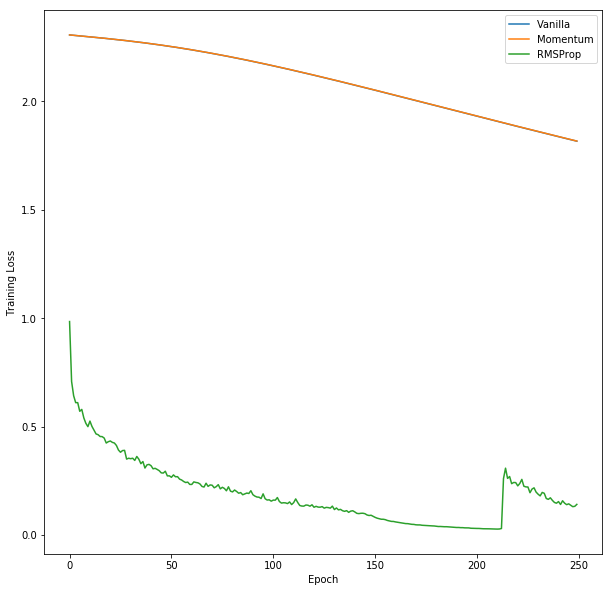

In [12]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10,10)

plt.plot(vanilla_loss, label='Vanilla')
plt.plot(momentum_loss, label='Momentum')
plt.plot(RMS_loss, label='RMSProp')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.show()

# Adam Gradient Descent 

Now we put them both together and we get Adam!

$$m_{t}=\beta_{1} m_{t-1} + (1 - \beta_{1})\nabla f(\theta_{t-1})$$
---

$$v_{t} = \beta_{2}v_{t-1} + (1 - \beta_{2})\nabla f(\theta_{t-1})^2$$
---

$$\hat m_{t} = \frac {m_{t}}{1 - \beta_1^{t}}$$
---

$$\hat v_t = \frac {v_{t}}{1 - \beta_2^{t}}$$
---

$$\theta_t = \theta_{t-1} - \alpha \frac {\hat m_t}{\sqrt{\hat v_t + \epsilon}} \tag{4}$$
---

Play around with the hyperparameters to see if you can get distinctly different behavior from the optimization.

In [13]:
"""
Adam Gradient Descent
"""

# Hyper Parameters
eta = 1e-5
initial_batch_size = 104
epochs = 250
beta1 = 0.9
beta2 = 0.999999
lileta = 1e-8
"""
You need to add 3 hyper parameters here. Hint! look at the equation above
"""


# Initialize random parameter matrices
np.random.seed(42)
W1 = 0.001 * np.random.randn(n_0, n_1)
W2 = 0.001 * np.random.randn(n_1, N)

b1 = 0.1 * np.random.randn(1, n_1)
b2 = 0.1 * np.random.randn(1, N)

# data for analysis
Adam_loss = []

v2W1 = np.zeros_like(W1)
v2W2 = np.zeros_like(W2)
v2b1 = np.zeros_like(b1)
v2b2 = np.zeros_like(b2)
m_t_w1 = np.zeros_like(W1)
m_t_w2 = np.zeros_like(W2)
m_t_b1 = np.zeros_like(b1)
m_t_b2 = np.zeros_like(b2)




# Perform gradient descent
for i in range(epochs):

    # generate mini batches
    x_batches, y_batches, num_batches, actual_batch_size = mini_batch(X, one_hot_y_actual, initial_batch_size)

    # perform gradient descent on mini batches
    for j in range(num_batches):
        y_pred, Z1 = feedforward(x_batches[j], W1, W2, b1, b2)

        """
        These are your gradients with respect to weight matrices W1 and W2 
        as well as your biases b1 and b2
        """
        grad_W1, grad_W2, grad_b1, grad_b2 = backpropogate(y_pred, Z1, x_batches[j], y_batches[j])
        
        m_t_w1 = beta*m_t_w1 + (1-beta)*grad_W1
        m_t_w2 = beta*m_t_w2 + (1-beta)*grad_W2
        m_t_b1 = beta*m_t_b1 + (1-beta)*grad_b1
        m_t_b2 = beta*m_t_b2 + (1-beta)*grad_b2

        v2W1 = beta2*v2W1 + (1-beta2)*(grad_W1**2)
        v2W2 = beta2*v2W2 + (1-beta2)*(grad_W2**2)
        v2b1 = beta2*v2b1 + (1-beta2)*(grad_b1**2)
        v2b2 = beta2*v2b2 + (1-beta2)*(grad_b2**2)
        
        mtmatw1 = m_t_w1 / (1 - beta1 )
        mtmatw2 = m_t_w2 / (1 - beta1 )
        mtmatb1 = m_t_b1 / (1 - beta1 )
        mtmatb2 = m_t_b2 / (1 - beta1 )
        
        v2hatw1 = v2W1 / ( 1 - beta2)
        v2hatw2 = v2W2 / ( 1 - beta2)
        v2hatb1 = v2b1 / ( 1 - beta2)
        v2hatb2 = v2b2 / ( 1 - beta2)
    
        
        
        W1 -= eta*mtmatw1/np.sqrt(v2hatw1 + lileta)
        W2 -= eta*mtmatw2/np.sqrt(v2hatw2 + lileta)
        b1 -= eta*mtmatb1/np.sqrt(v2hatb1 + lileta)
        b2 -= eta*mtmatb2/np.sqrt(v2hatb2 + lileta)


        

    # calc loss at end of each epoch
    y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
    Adam_loss.append(L(one_hot_y_actual, y_entire_pred, W1, W2))

    # Print some summary statistics every ten iterations
    if i % 10 == 0:
        y_pred_test, Z1_test = feedforward(X_test, W1, W2, b1, b2)
        acc = sum(y_test == np.argmax(y_pred_test, axis=1)) / len(y_test)
        y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
        print("Epoch %d Loss %f Accuracy %f" % (i, L(one_hot_y_actual, y_entire_pred, W1, W2), acc))


Epoch 0 Loss 2.160485 Accuracy 0.670857
Epoch 10 Loss 1.750909 Accuracy 0.842571
Epoch 20 Loss 1.561997 Accuracy 0.860286
Epoch 30 Loss 1.430833 Accuracy 0.870571
Epoch 40 Loss 1.329777 Accuracy 0.876000
Epoch 50 Loss 1.247771 Accuracy 0.881143
Epoch 60 Loss 1.179071 Accuracy 0.885714
Epoch 70 Loss 1.120236 Accuracy 0.887143
Epoch 80 Loss 1.069023 Accuracy 0.888000
Epoch 90 Loss 1.023876 Accuracy 0.889143
Epoch 100 Loss 0.983676 Accuracy 0.890000
Epoch 110 Loss 0.947576 Accuracy 0.891714
Epoch 120 Loss 0.914925 Accuracy 0.892286
Epoch 130 Loss 0.885210 Accuracy 0.893429
Epoch 140 Loss 0.858022 Accuracy 0.894571
Epoch 150 Loss 0.833025 Accuracy 0.896000
Epoch 160 Loss 0.809945 Accuracy 0.896571
Epoch 170 Loss 0.788555 Accuracy 0.897143
Epoch 180 Loss 0.768663 Accuracy 0.897429
Epoch 190 Loss 0.750106 Accuracy 0.898286
Epoch 200 Loss 0.732746 Accuracy 0.898286
Epoch 210 Loss 0.716460 Accuracy 0.899429
Epoch 220 Loss 0.701146 Accuracy 0.899429
Epoch 230 Loss 0.686712 Accuracy 0.900286
Epo

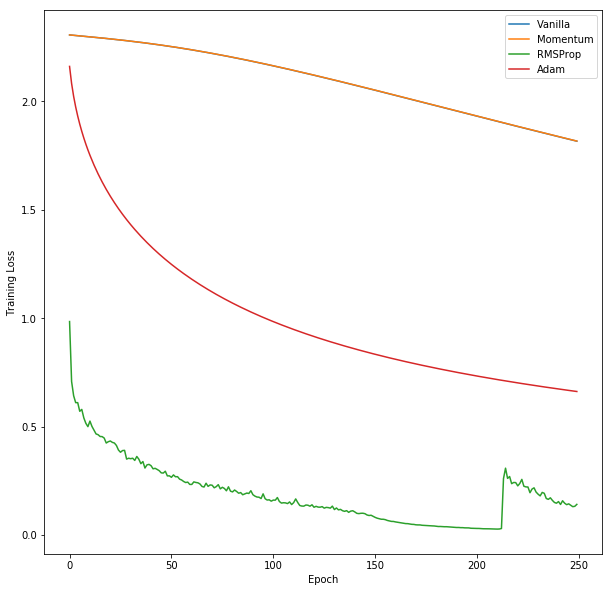

In [14]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10,10)

plt.plot(vanilla_loss, label='Vanilla')
plt.plot(momentum_loss, label='Momentum')
plt.plot(RMS_loss, label='RMSProp')
plt.plot(Adam_loss, label='Adam')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.show()